# How much are top merchants spending per order? Are we retaining these top buyers?

To accomplish in this notebook- 
- Define "Top buyer" - They come every month? They have spent the most money? They spend a certain amount every month?
- Recommend definition of "top buyers" 

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
baskets = pd.read_csv('new_baskets_full.csv')
baskets['datetime'] = baskets['placed_at'].apply(lambda x: datetime.fromisoformat(x))

#pandas.Series.dt is an interface on a pandas series that gives you convenient access to operations on data stored as a pandas datetime. 
baskets['date'] = baskets['datetime'].dt.date
baskets['year'] = baskets['datetime'].dt.year
baskets['month'] = baskets['datetime'].dt.month
baskets['day'] = baskets['datetime'].dt.day
baskets['hour'] = baskets['datetime'].dt.hour
baskets['weekday'] = baskets['datetime'].dt.weekday

#### Start by finding top buyers in terms of total amount spent.

In [2]:
baskets['spent'] = baskets['price'] * baskets['qty']

In [3]:
baskets.describe()

,id,order_id,merchant_id,sku_id,top_cat_id,sub_cat_id,qty,price,year,month,day,hour,weekday,spent
count,336472.000000,336472.000000,336472.000000,336472.000000,336461.000000,336461.000000,3.364720e+05,3.364720e+05,336472.000000,336472.000000,336472.000000,336472.000000,336472.000000,3.364720e+05
mean,168236.500000,29079.405656,798.592706,525.308685,10.319098,45.395065,3.789684e+01,1.378956e+05,2021.539941,6.659588,15.970758,12.702486,2.620928,5.346555e+05
std,97131.244225,18909.738357,550.271799,304.262943,7.906257,27.767388,1.035873e+04,1.744689e+05,0.498403,3.932984,8.796420,4.228485,1.831302,2.859301e+06
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,4.375000e-02,2021.000000,1.000000,1.000000,0.000000,0.000000,5.000000e+00
25%,84118.750000,11485.000000,352.000000,322.000000,4.000000,27.000000,1.000000e+00,4.600000e+04,2021.000000,3.000000,8.000000,10.000000,1.000000,1.165000e+05
50%,168236.500000,28436.000000,664.000000,438.000000,8.000000,43.000000,2.000000e+00,1.070000e+05,2022.000000,7.000000,16.000000,12.000000,3.000000,2.080000e+05
75%,252354.250000,46193.250000,1217.000000,589.000000,14.000000,69.000000,5.000000e+00,1.845000e+05,2022.000000,11.000000,24.000000,15.000000,4.000000,4.350000e+05
max,336472.000000,62048.000000,2138.000000,1617.000000,33.000000,96.000000,4.800000e+06,5.875000e+07,2022.000000,12.000000,31.000000,23.000000,6.000000,3.831222e+08


Remove first 5 months of data from dataframe.

In [5]:
baskets.date.min()

datetime.date(2021, 4, 9)

In [6]:
baskets = baskets[baskets['date'] > pd.to_datetime('2021-7-31').date()]

In [8]:
baskets.date.min()

datetime.date(2021, 8, 1)

Find total amount spent by each merchant and sort highest to lowest.

In [7]:
baskets.groupby('merchant_id').spent.sum().sort_values(ascending = False)

merchant_id
664     3.947079e+09
441     1.729729e+09
366     1.724671e+09
122     1.491349e+09
430     1.441119e+09
            ...     
1158    3.575000e+05
1931    3.450000e+05
2018    3.290000e+05
411     3.190000e+05
1157    2.459000e+05
Name: spent, Length: 2128, dtype: float64

Notice that the top 5 most spending merchants are 664,441,366,122,430. Lets plot their spending over time to see if they are consistent spenders.

In [9]:
baskets['month_order'] = baskets['year']*12 + baskets['month']

Created month_order to reindex data to start at end of july

Created options to parse through top 5 spenders

In [10]:
options = [664,441,366,122,430]

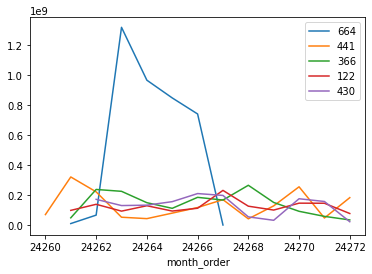

In [11]:
for i in range(5):
    baskets[baskets['merchant_id']==options[i]].groupby('month_order')['spent'].sum().plot().legend([664,441,366,122,430],fancybox = True)


Merchant 664 has a very unique buying pattern- looks like their last purchase was in March of 2022. They are defnitely an outlier, and seem to no longer be a customer. Remove 664 as top contender.

In [13]:
baskets[baskets['merchant_id'] == 664].date.max()

datetime.date(2022, 3, 25)

In [14]:
baskets = baskets.drop(baskets[baskets['merchant_id']== 664].index)

Now re-run data without 664.

In [15]:
baskets.groupby('merchant_id').spent.sum().sort_values(ascending = False)

merchant_id
441     1.729729e+09
366     1.724671e+09
122     1.491349e+09
430     1.441119e+09
305     1.368091e+09
            ...     
1158    3.575000e+05
1931    3.450000e+05
2018    3.290000e+05
411     3.190000e+05
1157    2.459000e+05
Name: spent, Length: 2127, dtype: float64

In [16]:
options = [441,366,122,430,305]

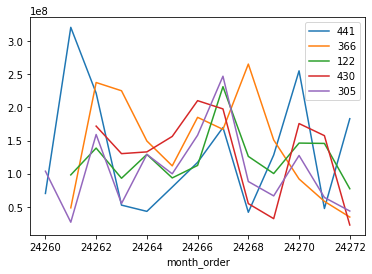

In [17]:
for i in range(5):
    baskets[baskets['merchant_id']==options[i]].groupby('month_order')['spent'].sum().plot().legend([441,366,122,430,305],fancybox = True)


This looks a lot better. Notice how all purchasing seems to fall between December and February? Why is this? It then also dips dramatically during Ramadon, which makes more sense *look into this later.

## Let's compare spending in the last 6 months. Will the same buyers be in the list?

In [18]:
sixbaskets = baskets[baskets['month_order'] > 24265]

In [19]:
sixbaskets.head()

,id,order_id,placed_at,merchant_id,sku_id,top_cat_id,sub_cat_id,qty,price,datetime,date,year,month,day,hour,weekday,spent,month_order
191588,191782,33178,2022-02-01 04:59:15.772,1425,378,8.0,43.0,1,100500.0,2022-02-01 04:59:15.772,2022-02-01,2022,2,1,4,1,100500.0,24266
191589,191783,33178,2022-02-01 04:59:15.772,1425,380,8.0,43.0,1,100500.0,2022-02-01 04:59:15.772,2022-02-01,2022,2,1,4,1,100500.0,24266
191590,191784,33178,2022-02-01 04:59:15.772,1425,383,8.0,43.0,1,100500.0,2022-02-01 04:59:15.772,2022-02-01,2022,2,1,4,1,100500.0,24266
191591,191749,33923,2022-02-01 06:53:29.594,1702,511,3.0,91.0,1,104000.0,2022-02-01 06:53:29.594,2022-02-01,2022,2,1,6,1,104000.0,24266
191592,191750,33923,2022-02-01 06:53:29.594,1702,522,3.0,94.0,10,176000.0,2022-02-01 06:53:29.594,2022-02-01,2022,2,1,6,1,1760000.0,24266


In [20]:
sixbaskets.groupby('merchant_id').spent.sum().sort_values(ascending = False)

merchant_id
497     959077900.0
366     952641100.0
441     941911050.0
122     938894750.0
2084    932772739.0
           ...     
484        137500.0
195        123000.0
643         99500.0
706         62000.0
1435        53500.0
Name: spent, Length: 1728, dtype: float64

Top spenders are merchant_id's 497,366,441,122,2048.

441,366,122,430,305 were the top spenders over the year, it seems that 497 and 2048 have spent a lot more in the second half, while 430 and 305 have not sustained their high spending as much in the second half. 

In [22]:
options = [497,366,441,122,2048]

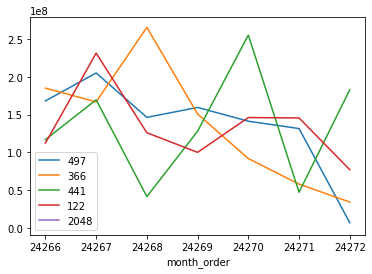

In [23]:
for i in range(5):
    sixbaskets[sixbaskets['merchant_id']==options[i]].groupby('month_order')['spent'].sum().plot().legend([497,366,441,122,2048],fancybox = True)


Looks like all sales are declining in July of 2022 besides 441. Why is this? 441 seems to have a regular pattern of large orders every two months. They are consistent, which is valuable. There are not any outliers, so let's look at the sales from 430 and 305 in the second half to see if they are still top buyers. 

Looking at this new graph, I see no outliers, everyone is still purchasing now semi-consitently.
For the monetary score, I am going to use the data from the whole year. This is because changes in the last 6 months may be more relevant to the frequency score. 
Top 5 are: 
1. 441 (5)
2. 366 (4)
3. 122 (3)
4. 430 (2)
5. 305 (1)

RFM- recency, frequency, monetary. 
Find matrix to rank buyers by all three. 
R+F+M = Score. 
Recency is not as relevant

## Next, I am going to work on frequency: The angle I will take to rank frequency is whoever has the highest average number of transactions per month.

In [30]:
baskets['this_month'] = baskets.groupby('month_order').order_id.nunique().sum()

In [31]:
ex = baskets.sample(20)
ex.head()

,id,order_id,placed_at,merchant_id,sku_id,top_cat_id,sub_cat_id,qty,price,datetime,date,year,month,day,hour,weekday,spent,month_order,this_month
99966,93523,13399,2021-11-19 20:58:48.765,504,510,11.0,27.0,2,352500.0,2021-11-19 20:58:48.765,2021-11-19,2021,11,19,20,4,705000.0,24263,61355
290674,290765,53117,2022-05-18 11:33:05.470,413,941,3.0,94.0,2,153000.0,2022-05-18 11:33:05.470,2022-05-18,2022,5,18,11,2,306000.0,24269,61355
127674,127819,19991,2021-12-08 15:02:39.045,337,522,3.0,94.0,2,159500.0,2021-12-08 15:02:39.045,2021-12-08,2021,12,8,15,2,319000.0,24264,61355
277420,277581,51064,2022-04-25 19:48:09.490,2037,970,4.0,28.0,3,94000.0,2022-04-25 19:48:09.490,2022-04-25,2022,4,25,19,0,282000.0,24268,61355
178054,176636,29786,2022-01-21 06:12:47.257,295,390,4.0,51.0,32,18450.0,2022-01-21 06:12:47.257,2022-01-21,2022,1,21,6,4,590400.0,24265,61355
